# Large-scale Wilson-Cowan neural mass model

Consistent with previous studies (e.g., [Papadopoulos et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144)), the coarse-grained form of the Wilson-Cowan equations ([Wilson & Cowan, 1972](https://www.sciencedirect.com/science/article/pii/S0006349572860685)) for the $i$-th brain region can be expressed as:

$$\tau_{E} \frac{dE_i(t)} {dt} = - E_i(t) + (1- E_i(t))f_{E}[w_{EE}E_i(t) - w_{IE}I_i(t)+G\sum_j w_{ji}E_{j}(t-d)+P_{E}] + \epsilon_{i}^{OU}(t)$$

$$\tau_{I} \frac{dI_i(t)} {dt} = - I_i(t) + (1- I_i(t))f_{I}(w_{EI}E_i(t)-w_{II}I_i(t)+P_{I}) + \epsilon_{i}^{OU}(t)$$

The variables $E_i(t)$ and $I_i(t)$ correspond to neuronal activity of the excitatory and inhibitory subpopulations of the $i$-th region (proportion of excitatory and inhibitory cells firing per unit time), $\tau_E$ and $\tau_I$ are the excitatory and inhibitory time constants, and $w_{EE}$, $w_{IE}$, $w_{EI}$ and $w_{II}$ are the connectivity coefficients between excitatory and inhibitory subpopulations representing the average number of excitatory and inhibitory synapses per cell (synaptic weights). The non-linear response functions $ƒ_E$ and $ƒ_I$ for excitatory and inhibitory subpopulations are defined as:
                       
$$f_E(x) =\frac{c_E} {(1 + \exp(-a_E  (x - b_E))}$$
                   
$$f_I(x) =\frac{c_I} {(1 + \exp(-a_I  (x - b_E))}$$

where $a_E$ and $a_I$ are the slopes, $b_E$ and $b_I$ are the positions of the maximum slope, $c_E$ and $c_I$ are the amplitudes of excitatory and inhibitory response functions.

The $G\sum_j w_{ji}E_{j}(t-d)$ term represents interactions of the $i$-th region with the rest of the network, $G$ is the global coupling parameter, $w_{ji}$ is the synaptic weight from the $j$-th to $i$-th region, and $d$ is the signal transmission delay between brain regions. The signal transmission delay was d = 25 ms, which is a physiologically plausible value for humans as estimated by [Ringo et al. (1994)](https://psycnet.apa.org/doi/10.1093/cercor/4.4.331). Synaptic weights ($w_{ji}$) were changed according to stimulus onsets.

The $P_E$ and $P_I$ terms are constant, background drive for excitatory and inhibitory subpopulations. The $\epsilon_{i}^{OU}$ term is the background noise modelled as an Ornstein-Uhlenbeck process with zero mean ([Uhlenbeck & Ornstein, 1930](https://doi.org/10.1103/PhysRev.36.823); [Cakan et al., 2021](https://doi.org/10.1007/s12559-021-09931-9), [2022](https://doi.org/10.3389/fncom.2021.800101)):

$$\frac{d\epsilon_{i}^{OU}(t)} {dt} = \frac{-OU_i(t)} {\tau_{OU}} + \sigma_{OU}*\epsilon_i(t)$$

where $\tau_{OU}$ is the time scale, $\sigma_{OU}$ is the standard deviation of the process, and $\epsilon_i$ is the white Gaussian noise.

Synaptic activity can be calculated as the sum of all inputs to the excitatory and inhibitory subpopulations ([Tagamets & Horwitz, 1998](https://doi.org/10.1093/cercor/8.4.310); [Kim & Horwitz, 2007](https://doi.org/10.1016/j.mri.2007.10.011); [Ulloa & Horwitz, 2016](https://doi.org/10.3389/fninf.2016.00032)):

$$SA_i(t) = w_{EE}E_i(t) + w_{EI}E_i(t) + w_{II}I_i(t) + w_{IE}I_i(t) + \sum_j w_{ji}E_j(t)$$

Synaptic activity $SA_i(t)$ was considered as a proxy for local field potential (LFP) and used as input to the Balloon-Windkessel model.

Numerical integration of the system of ordinary differential equations was performed using the Euler-Maruyama method with a time step of dt = 0.1 ms, implemented in the neurolib software (https://github.com/neurolib-dev/neurolib). Neurolib is a Python library that provides a computationally efficient framework for whole-brain resting-state functional connectivity (RSFC) simulations ([Cakan et al., 2021](https://doi.org/10.1007/s12559-021-09931-9)). In the current study, we modified the neurolib software to perform task-modulated functional connectivity (TMFC) simulations for a given task design and temporal resolution.



In [1]:
from tqdm import tqdm
import xarray as xr
import os
import seaborn as sns
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")
from scipy import signal, stats, io
from neurolib.models.wc import WCModel
from neurolib.models import bold
from tmfc_simulation import functions
from tmfc_simulation.read_utils import read_onsets_from_mat, generate_sw_matrices_from_mat
from tmfc_simulation.wilson_cowan_task_simulation import WCTaskSim, HRF
from tmfc_simulation.synaptic_weights_matrices import normalize, generate_synaptic_weights_matrices
import numpy as np
import gc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
matplotlib.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

## Setting up WC model parameters 

All fixed parameters of the Wilson-Cowan model were selected as in [Papadopoulos et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144): 

<img src = "illustrations/WC_parameters.PNG" width = 800>

Three tuning parameters ($G$, $P_E$, $\tau_{OU}$) were determined based on the maximum similarity between the ground-truth synaptic weight matrix and the task-modulated functional connectivity (TMFC) matrix estimated using the direct correlation difference (CorrDiff) approach for block design time series without scanner measurement error. Similarity between matrices was assessed using Pearson’s r correlation.



In [2]:
wc_params = {'exc_ext': 0.758, # excitatory background drive
             'K_gl': 2.63, # global coupling parameter
             'sigma_ou': 0.0035, # std of the Ornstein-Uhlenbeck noise
             'inh_ext': 0, # inhibitory background drive
             'tau_ou': 5, # [ms] timescale of the Ornstein-Uhlenbeck noise
             'a_exc': 1.5, # slope of excitatory response function
             'a_inh': 1.5, # slope of inhibitory response function
             'c_excexc': 16, # E-to-E synaptic weight
             'c_excinh': 15, # E-to-I synaptic weight
             'c_inhexc': 12, # I-to-E synaptic weight
             'c_inhinh': 3, # I-to-I synaptic weight
             'mu_exc': 3,  # position of maximum slope of excitatory response function
             'mu_inh': 3,  # Position of maximum slope of inhibitory response function
             'tau_exc': 2.5, # excitatory time constant
             'tau_inh': 3.75, # inhibitory time constant
             'signalV': 10 # signal transmission speed between areas [m/s]
            }

## Download task design info 

If **SMALL = False**, a full simulation will be performed (using all stimulus onset times from task design *.mat file).

If **SMALL = True**, short simulation will be performed for tesing purposes (using several first two stimulus onset times).

In [3]:
SMALL = False
mat_path = '../task_designs/02_EVENT_[2s_TR]_[1s_DUR]_[6s_ISI]_[100_TRIALS].mat'
input_data = io.loadmat(mat_path)
if SMALL:
    small_input_data = input_data.copy()
    small_input_data['onsets'][0,0] = input_data['onsets'][0,0][:2]
    small_input_data['onsets'][0,1] = input_data['onsets'][0,1][:2]
    small_mat_path = os.path.join(os.path.dirname(mat_path),'small_'+os.path.basename(mat_path))
    io.savemat(small_mat_path, small_input_data)
    mat_path = small_mat_path
print(f"Task design file {os.path.basename(mat_path)} will be used for simulation")    

Task design file 02_EVENT_[2s_TR]_[1s_DUR]_[6s_ISI]_[100_TRIALS].mat will be used for simulation


## Generation of synaptic weight matrices

The construction of the synaptic weight matrices involved three steps.

First, we drew synaptic weights for each subject from a Gaussian distribution with a mean of one and a standard deviation of *SIGMA = 0.1*. 

Then, we multiplied the synaptic weights within and between functional modules by weighting factors that determined the network structure:

<img src = "illustrations/weighting_factors_for_synaptic_matrices.PNG" width = 800>

Weighting factors are specified in task design .mat files (*rest_matrix* and *task_matrices* structures).

Finally, we normalised the synaptic weights so that all inputs to each region summed to one, following previous simulation studies ([Cole et al., 2019](https://doi.org/10.1016/j.neuroimage.2018.12.054), [Papadopoulos et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008144)).

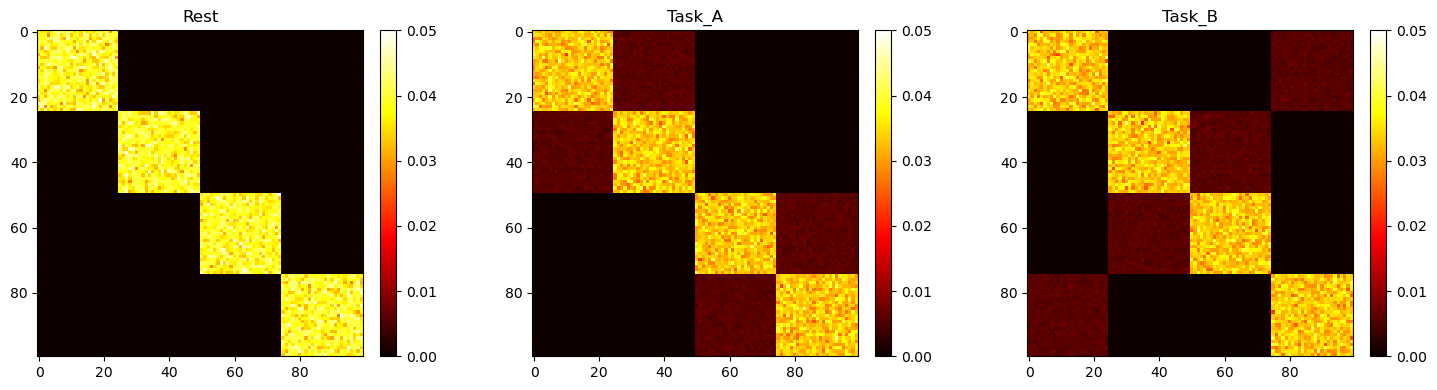

In [4]:
N_ROIs = 100 # number of brain regions
SIGMA = 0.1 # standard deviation of Gaussian distribution for synaptic weights generation
NORM_TYPE = "cols" # normalize by columns (all inputs to each region summed to one)
NUM_MODULES = 4 # number of functional modules 
GEN_TYPE = 'simple_prod' # generation type, simple_prod or equal_var

#generate matrices using weighting factors, which we specified in "task_matrices" and "rest_matrices" sturctures of the task design .mat file
Wij_rest, Wij_task_dict = generate_sw_matrices_from_mat(mat_path, N_ROIs, num_modules=NUM_MODULES,
                                sigma=SIGMA, norm_type=NORM_TYPE, gen_type = GEN_TYPE)
Wij_task_list = list(Wij_task_dict.values())
Wij_list = [Wij_rest]+Wij_task_list
title_list =['Rest']+ list(Wij_task_dict.keys())
fig, axs = plt.subplots(1, 3, figsize = (15,4))

#list of possible colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
for i in [0,1,2]:
    im = axs[i].imshow(Wij_list[i], cmap='hot', vmin = 0, vmax=0.05); axs[i].set_title(title_list[i]);
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()

In [5]:
Wij_task_dict["Rest"] = Wij_rest
io.savemat("../synaptic_weights.mat", Wij_task_dict)

## Balloon-Windkessel haemodynamic model

Simulated neuronal activity was converted to the BOLD signal using the Balloon-Windkessel haemodynamic model ([Friston et al., 2003](https://www.sciencedirect.com/science/article/pii/S1053811903002027)). 

To introduce hemodynamic response variability across ROIs and subjects we used these parameters:

<img src = "illustrations/Variable_BW_parameters.PNG" width = 800>

$$k1 = 7\rho$$
$$k2 = 2$$
$$k3 = 2\rho - 0.2$$

In [6]:
k, var_k = 0.65, 0.015
gamma, var_gamma = 0.41, 0.002*4
tau, var_tau = 2.5, 0.0568*4
alpha, var_alpha = 0.32, 0.0015*4
rho, var_rho = 0.34, 0.0024*4
K = np.random.normal(k, np.sqrt(var_k), size=(N_ROIs,))
Gamma = np.random.normal(gamma, np.sqrt(var_gamma), size=(N_ROIs,))
Tau = np.random.normal(tau, np.sqrt(var_tau), size=(N_ROIs,))
Alpha = np.random.normal(alpha, np.sqrt(var_alpha), size=(N_ROIs,))
Rho = np.random.normal(rho, np.sqrt(var_rho), size=(N_ROIs,))
bw_params = {"k":K, "gamma":Gamma, "tau":Tau, "alpha": Alpha, "rho": Rho}

## Simulation settings

Here we define the remaining simulation parameters:
    
 - :: delay (int or np.array of ints) - delay parameter, fiber length [in mm] (delay = 250 mm and signalV = 10 m/s result in signal transmission delay d = 25 ms) 
 - :: rest_before (True, False) - if we need to generate "rest" time points before zero time moment (dummy scans)
 - :: first_duration (default 12)  - duration of the rest period before zero time moment (dummy scans) [in seconds]
 - :: last_duration (default 8) - duration of the rest period at the end of simulation [in seconds]
 - :: TR (default 2) - repetition time for BOLD signal downsampling [in seconds]
 - :: activity (bool) - if True original neural activity will be saved with a_s_rate 
 - :: a_s_rate (default 0.02) - neuronal activity sampling rate [in seconds]
 - :: act_type (default 'syn_act') - neural oscillation type used for BOLD signal computation, available 'exc' (only exctitatory subpopulations),'syn_act' (synaptic activity),'both'
 - :: normalize_max (default 2) - normalization constant used for BOLD input transformation
 

In [7]:
sim_parameters = {"delay": 250,"rest_before":True, "first_duration": 6, "last_duration": 20}
TR = 2
act_type = 'syn_act'
normalize_max = 0.001
a_s_rate = 5*1e-3 # downsampled time step (used for PLV and gamma-band envelope calculation)
activity = True

In [8]:
setting_dict = {**wc_params, **sim_parameters, **{ key:value for (key,value) in bw_params.items() if value is not None}, 'a_s_rate': a_s_rate, 'TR': TR}
resmatfile = os.path.join(os.path.dirname(mat_path),'SIM_SET_'
                        +os.path.basename(mat_path))
io.savemat(resmatfile, setting_dict)

In [9]:
%%time

wc_sim = WCTaskSim.from_matlab_structure(mat_path, sigma=SIGMA, norm_type=NORM_TYPE, num_modules=NUM_MODULES, 
                                               num_regions= N_ROIs, **wc_params, **sim_parameters,  gen_type = GEN_TYPE)
wc_sim.generate_full_series(TR=TR, activity=activity, a_s_rate=a_s_rate, clear_raw=False,
                              normalize_max=normalize_max, output_activation=act_type, **bw_params)

CPU times: total: 6min 3s
Wall time: 5min 34s


## Co-activations

We independently simulated co-activations using box-car functions to evaluate their impact on spurious inflation of TMFC estimates.

Neuronal activity = Oscillations (WC model) + Co-activations (box-car functions)

In the input file we have parameters with additional local activation for each condition, two arrays with the dimension equal to NUM_MODULES.


In [10]:
%%time
print("Local activation: ",input_data["activations"])
t_coactiv, _, bold_coactiv = wc_sim.generate_coactivation_by_mat(mat_path, dt = 50, act_scaling=0.0015, **bw_params)

Local activation:  [[array([[1, 0, 1, 0]], dtype=uint8) array([[0, 1, 0, 1]], dtype=uint8)]]
CPU times: total: 125 ms
Wall time: 136 ms


Local activation:  [[array([[1, 0, 1, 0]], dtype=uint8) array([[0, 1, 0, 1]], dtype=uint8)]]


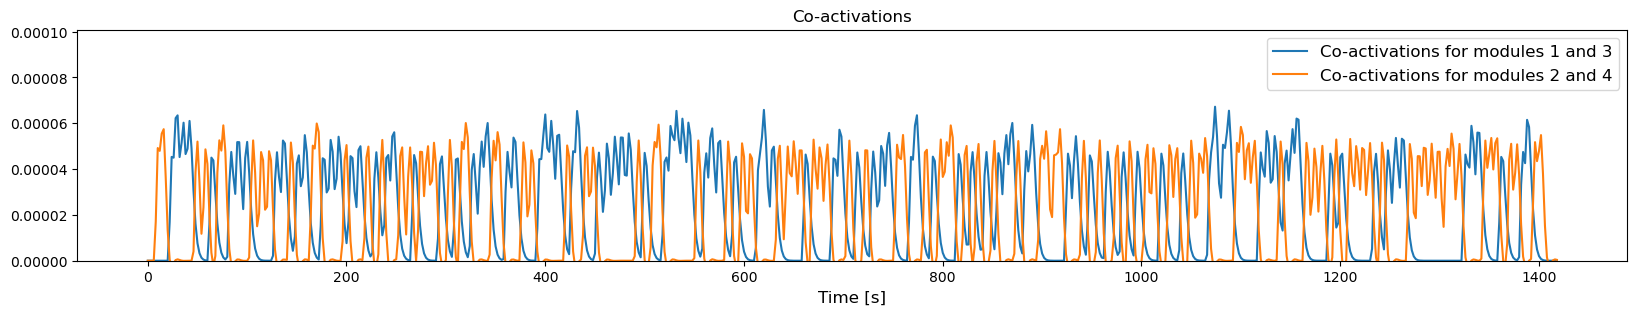

In [11]:
print("Local activation: ",input_data["activations"])
figure(figsize=(20, 3))
plt.plot(t_coactiv/1e3, bold_coactiv[1,:], label = 'Co-activations for modules 1 and 3');
plt.plot(t_coactiv/1e3, bold_coactiv[26,:], label = 'Co-activations for modules 2 and 4');
plt.ylim(10*np.min(bold_coactiv[1,:]), 1.5*np.max(bold_coactiv[1,:]))
plt.xlabel('Time [s]', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Co-activations', fontsize = 12);

## Results
## Power spectrum

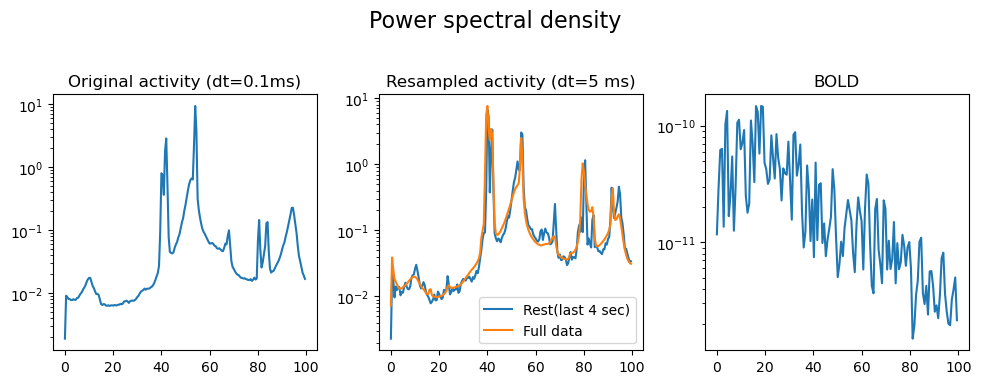

In [12]:
# power spectrum 
syn_act = wc_sim.generate_neuronal_oscill()
fig, axs = plt.subplots(1, 3, figsize = (10,4))
maxfr = 100
windowsize = 2;
f1, Pxx_Welsh1 =  functions.getMeanPowerSpectrum(syn_act,0.1, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[0].semilogy(f1,  Pxx_Welsh1); axs[0].set_title('Original activity (dt=0.1ms)', fontsize=12);
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(wc_sim.activity["sa_series"][:,-400:],5, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[1].semilogy(f,  Pxx_Welsh, label="Rest(last 4 sec)"); axs[1].set_title('Resampled activity (dt=5 ms)', fontsize=12);
fig.suptitle("Power spectral density", fontsize=16); 
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(wc_sim.activity["sa_series"],5, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[1].semilogy(f,  Pxx_Welsh, label="Full data");
axs[1].legend();
f2, Pxx_Welsh2 =  functions.getMeanPowerSpectrum(wc_sim.BOLD,2, spectrum_windowsize=windowsize, maxfr=maxfr)
axs[2].semilogy(f2,  Pxx_Welsh2); axs[2].set_title('BOLD', fontsize=12);

In [13]:
results_dict = {"PowerDensity_WC_Original": np.array([f1, Pxx_Welsh1]),"PowerDensity_WC_Resampled": np.array([f, Pxx_Welsh]), "PowerDensity_BOLD": np.array([f2, Pxx_Welsh2])}
io.savemat(resmatfile, {**results_dict, **setting_dict})

In [14]:
resmatfile

'../task_designs\\SIM_SET_02_EVENT_[2s_TR]_[1s_DUR]_[6s_ISI]_[100_TRIALS].mat'

## Neuronal synchronization

Raw time series were downsampled from a temporal resolution of 0.1 ms to 5 ms and bandpass filtered it in a narrow carrier frequency range $[f_{carrier} – 2 Hz, f_{carrier} + 2 Hz]$, where $f_{carrier} = 40 Hz$. Next, we employed the Hilbert transform to obtain the instantaneous amplitudes and phases of the narrowband signal. The instantaneous amplitudes, or amplitude envelopes, were further cross-correlated with the simulated BOLD signals, while the instantaneous phases were utilised to estimate gamma-band neuronal synchronisation based on the phase-locking value (PLV) method ([Lachaux et al., 1999](https://pubmed.ncbi.nlm.nih.gov/10619414/)).

In [15]:
ds = wc_sim.compute_phase_diff(series_name = 'sa_series', low_f=38, high_f=42, return_xr=True)

CPU times: total: 1min 19s
Wall time: 1min 34s


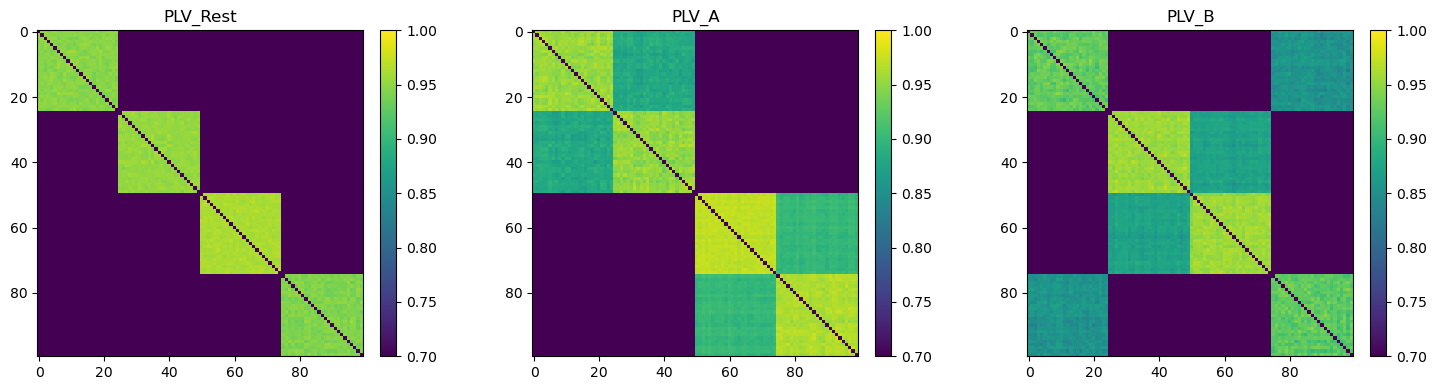

In [16]:
%%time

def mean_abs(x, dim=None):
    return abs(np.exp(1j * x).mean(dim=dim))
tasks = ['Rest','A','B']
N_ROIs = ds.dims['region']
title_list = ['PLV_Rest','PLV_A', 'PLV_B']
roi_idx1, roi_idx2 = np.triu_indices(N_ROIs,k=1)
fig, axs = plt.subplots(1, 3, figsize = (15,4))
PLV_dict_keys = ['PLV_REST','PLV_A', 'PLV_B']
PLV_dict = {}
#PLV computation takes a long time, so we can take smaller subset (SUBSET = TRUE)
SUBSET = False
last_time = 100 
for i in [0,1,2]:
    if SUBSET:
        synh = ds.sel(time=slice(0,last_time*1000)).groupby('task_type')[tasks[i]].map(mean_abs, dim = 'time').phase_diff.data
    else:
        synh = ds.groupby('task_type')[tasks[i]].map(mean_abs, dim = 'time').phase_diff.data
    sym_synh = 0.3*np.eye(N_ROIs)
    sym_synh[roi_idx1, roi_idx2] = synh
    matx = sym_synh+sym_synh.T
    im = axs[i].imshow(matx, cmap='viridis', vmin = 0.7, vmax=1); axs[i].set_title(title_list[i]);
    PLV_dict[PLV_dict_keys[i]]= matx
    
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()

In [17]:
io.savemat(resmatfile, {**results_dict, **setting_dict, **PLV_dict})

## Gamma-band envelope and BOLD-signal 

Compute cross-correlation between gamma-band envelope and BOLD-signal

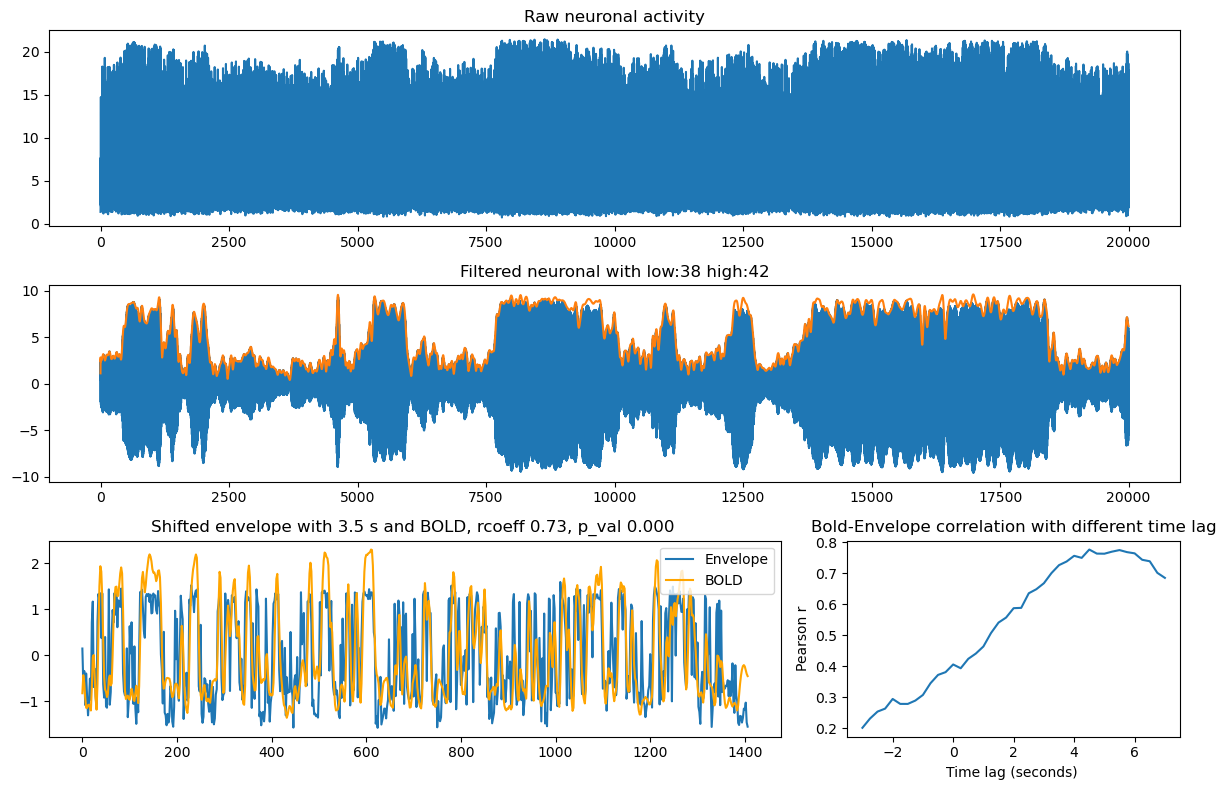

In [18]:
env_dict = wc_sim.draw_envelope_bold_compare(node_id=2, series_name = 'sa_series', low_f=38, high_f=42, low_pass=None, 
                               drop_first_sec=10, shift_sec = 3.5,  plot_first = 100)

In [19]:
io.savemat(resmatfile, {**results_dict, **setting_dict, **PLV_dict, **env_dict})

In [20]:
resmatfile

'../task_designs\\SIM_SET_02_EVENT_[2s_TR]_[1s_DUR]_[6s_ISI]_[100_TRIALS].mat'

##  Generate BOLD time series for N subjects and save to .mat file

In [21]:
N_ROIs, mat_path

(100, '../task_designs/02_EVENT_[2s_TR]_[1s_DUR]_[6s_ISI]_[100_TRIALS].mat')

In [22]:
%%time
N_subj=100

k, var_k = 0.65, 0.015
gamma, var_gamma = 0.41, 0.002*4
tau, var_tau = 2.5, 0.0568*4
alpha, var_alpha = 0.32, 0.0015*4
rho, var_rho = 0.34, 0.0024*4

BOLD_oscill_subj = np.zeros((*wc_sim.BOLD.transpose().shape,N_subj))
BOLD_coact_subj = np.zeros((*bold_coactiv.transpose().shape,N_subj))

for i in tqdm(range(N_subj)):
    wc_sim = WCTaskSim.from_matlab_structure(mat_path, sigma=SIGMA, norm_type=NORM_TYPE, num_modules=NUM_MODULES, 
                                               num_regions= N_ROIs, **wc_params, **sim_parameters,  gen_type = GEN_TYPE)
    
    K = np.random.normal(k, np.sqrt(var_k), size=(N_ROIs,))
    Gamma = np.random.normal(gamma, np.sqrt(var_gamma), size=(N_ROIs,))
    Tau = np.random.normal(tau, np.sqrt(var_tau), size=(N_ROIs,))
    Alpha = np.random.normal(alpha, np.sqrt(var_alpha), size=(N_ROIs,))
    Rho = np.random.normal(rho, np.sqrt(var_rho), size=(N_ROIs,))
    bw_params = {"k":K, "gamma":Gamma, "tau":Tau, "alpha": Alpha, "rho": Rho}

    wc_sim.generate_full_series(TR=TR, activity=False, a_s_rate=a_s_rate, clear_raw=True,
                              normalize_max=normalize_max, output_activation=act_type, **bw_params)

    t_coactiv, coactiv, bold_coactiv = wc_sim.generate_coactivation_by_mat(mat_path, dt = 50, act_scaling=0.0015, **bw_params)
    
    BOLD_oscill_subj[:,:,i] = wc_sim.BOLD.transpose()
    BOLD_coact_subj[:,:,i] = bold_coactiv.transpose()


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [10:06:15<00:00, 363.76s/it]

CPU times: total: 11h 7min 29s
Wall time: 10h 6min 15s


In [23]:
boldmatfile = os.path.join(os.path.dirname(mat_path),'SIM_BOLD_'
                        +os.path.basename(mat_path))
bold_dict = {'oscill': BOLD_oscill_subj, 'coact': BOLD_coact_subj}
io.savemat(boldmatfile, bold_dict)